# Implementing a neural network in low-level tensorflow without eager execution

This notebook implements a simple multilayer perceptron for the Boston Housing data.

First we create placeholder tensors for the inputs and output variables.

In [1]:
import tensorflow as tf
x = tf.placeholder(dtype=tf.float32, shape=(None, 13))
y = tf.placeholder(dtype=tf.float32, shape=(None, 1))

Next we create a function which will perform a linear transformation of its input. This takes care of creating the variable tensors for the biases and weights. Tensorflow keeps track of all the variable tensors we create, so there is no need for us to store them in a data structure. We could store them if we particularly wanted to refer to them later e.g. to inspect their value or to use them in a penalisation variable. (An alternative method is to use [tensor names](https://www.tensorflow.org/programmers_guide/variables).)

In [2]:
def linear_transform(inputs, ninputs, noutputs):
    bias = tf.Variable(tf.random_normal([noutputs], stddev=0.05))
    weights = tf.Variable(tf.random_normal([ninputs, noutputs], stddev=0.05))
    return tf.matmul(inputs, weights) + bias

Now we create our neural network. I'm using the $tanh$ activation function for the intermediate layers as this small neural network is especially vulnerable to dead ReLUs. For the final layer I use a softplus activation function to ensure the output is positive.

In [3]:
sizes = [5, 3, 1]
ninputs = 13
layer1 = tf.nn.tanh(linear_transform(x, ninputs, sizes[0]))
layer2 = tf.nn.tanh(linear_transform(layer1, sizes[0], sizes[1]))
pred = tf.nn.softplus(linear_transform(layer2, sizes[1], sizes[2]))

Note that `pred` ends up being a 2-dimensional tensor, although it has only 1 column.

In [4]:
print(pred)

Tensor("Softplus:0", shape=(?, 1), dtype=float32)


We'll use mean squared error loss which can be implemented in Tensorflow as follows.

In [5]:
loss = tf.reduce_mean(tf.square(pred - y))

Now we create optimiser and training operators.

In [6]:
optimiser = tf.train.AdamOptimizer()
train = optimiser.minimize(loss)
init = tf.global_variables_initializer()

Next we start a Tensorflow session and initialise the variables.

In [7]:
sess = tf.Session()
sess.run(init)

Below we get the Boston Housing data, normalise it and reshape the outputs into 2-dimensional tensors (which are required because they must match our `pred` tensor which is 2-dimensional as noted above).

In [8]:
# Download data
import numpy as np
from keras.datasets import boston_housing
(x_train, y_train), (x_val, y_val) = boston_housing.load_data()
# Normalise data
x_mean = np.std(x_train, 0)
x_sd = np.std(x_train, 0)
for i in range(13):
    x_train[:,i] -= x_mean[i]
    x_train[:,i] /= x_sd[i]
    x_val[:,i] -= x_mean[i]
    x_val[:,i] /= x_sd[i]
# Reshape data
y_train = y_train.reshape((404,1))
y_val = y_val.reshape((102,1))

Using TensorFlow backend.


Let's split the data into batches.

In [9]:
nbatches = 10
xbatches = np.array_split(x_train, nbatches)
ybatches = np.array_split(y_train, nbatches)

Finally we can train the neural network.

In [10]:
for e in range(1, 5000):
  train_loss = 0.
  for (x_,y_) in zip(xbatches, ybatches):
      next_loss, _ = sess.run([loss, train], {x:x_, y:y_})
      train_loss += next_loss
  if e % 250 == 0:
    train_loss /= nbatches
    val_loss = sess.run(loss, {x:x_val, y:y_val})
    print("Epochs {:3d} Train loss {:.1f} Validation loss {:.1f}".format(e, train_loss, val_loss))

Epochs 250 Train loss 232.6 Validation loss 247.8
Epochs 500 Train loss 109.2 Validation loss 114.9
Epochs 750 Train loss 85.0 Validation loss 85.2
Epochs 1000 Train loss 31.8 Validation loss 34.4
Epochs 1250 Train loss 19.0 Validation loss 25.7
Epochs 1500 Train loss 11.8 Validation loss 23.6
Epochs 1750 Train loss 8.3 Validation loss 23.6
Epochs 2000 Train loss 6.7 Validation loss 24.5
Epochs 2250 Train loss 6.0 Validation loss 25.0
Epochs 2500 Train loss 5.6 Validation loss 24.4
Epochs 2750 Train loss 5.4 Validation loss 23.5
Epochs 3000 Train loss 5.3 Validation loss 22.9
Epochs 3250 Train loss 5.1 Validation loss 22.7
Epochs 3500 Train loss 5.1 Validation loss 22.6
Epochs 3750 Train loss 5.0 Validation loss 22.7
Epochs 4000 Train loss 4.9 Validation loss 22.8
Epochs 4250 Train loss 4.9 Validation loss 22.9
Epochs 4500 Train loss 4.8 Validation loss 22.9
Epochs 4750 Train loss 4.7 Validation loss 23.2


This run has achieved much better training loss than for linear regression and a similar validation loss - compare with Figure 2.1 of the notes. The difference between training and validation loss suggests significant overfitting. (On other training runs the evidence is even stronger due to a large validation loss!)

Also note that compared to the eager execution version, this runs much faster and gives similar results.

Let's look at our predictions.

In [11]:
predictions_train = sess.run(pred, {x:x_train})
predictions_val = sess.run(pred, {x:x_val})

In [12]:
import matplotlib.pyplot as plt

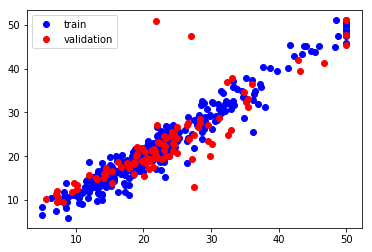

In [13]:
plt.plot(y_train, predictions_train, "bo", label="train")
plt.plot(y_val, predictions_val, "ro", label="validation")
plt.legend()

The training predictions look significantly improved compared to the linear regression values in Figure 2.2. One improvement is that we've prevented any negative predictions by using a softplus activation. Another is that house values close to 50 are no longer badly underestimated.

On the other hand the validation predictions contain several outlying predictions corroborating the earlier suspicion of overfitting. Regularisation of some sort would probably improve validation loss.

This example illustrates that neural networks can improve on linear regression even for small datasets. However the major benefits are for big datasets!